## 1, Introduction: “Expected Landing Position” of a Punted Football and Its Usage in Modern NFL Game

NFL has been one of the most popular sports in the United States and in the world. The sport, football, mainly consists of three play types: offense, defence and special team plays. For a long time, offense and defence are overwhelmingly emphasized on the field, since these two play types directly enable teams to evaluate their performances and achieve victories. Nevertheless special team plays, especially punting, is often overlooked due to the fact that many people believe that it is only the complementary part of the game. Does punting indeed affect the game and the players on the pitch? 

In this notebook, I am going to introduce a new metric called "Expected Landing Position" for a punted football. The function of this metric is to predict the approximate landing position on x and y axis of a punted football based on several selected features that can be extracted from the datasets provided. In order to calculate the "Expected Landing Position", I am going to build a machine learning model. This model enables NFL coaching staff and returners to input a set of features and it will return the displacement of the football on both x and y axis as the result. With this new metric and machine learning model, NFL teams and returners are able to know the rough position of a landed football, so that they could perform better at returning and achieve better returning yardage, which could be vital to a game.

## 2, Dataframe Construction
The code below only shows data preparation and cleaning processes of the 2020 tracking data as an example. I am going to process all three dataframes one by one in order to use momory in a more efficient way. The handling process of the 2019 and 2018 tracking data will be performed in an analogous way and in a hidden cell of code.

First of all, we are going to read the tracking data and figure out which information are relevant to calculating the displacement of a punted football.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing
import os

df = pd.read_csv('../input/nfl-big-data-bowl-2022/tracking2020.csv')
df = df.loc[df['team'] == 'football']
df = df.drop(columns = ['o', 'dir', 'nflId', 'jerseyNumber', 'position'])
pd.DataFrame(df.groupby(['event']).size().reset_index(name = "Count"))

,event,Count
0,None,490847
1,autoevent_kickoff,1567
2,ball_snap,3829
3,drop_kick,6
4,extra_point,1083
5,extra_point_attempt,1182
6,extra_point_blocked,10
7,extra_point_missed,71
8,fair_catch,510
9,field_goal,723


## 3, Data Cleaning and Target Dataset Construction

The metric "Expected Landing Position" includes two values: dx (displacement of football on the x axis) and dy (displacement of football on the y axis). In order to calculate the "Expected Landing Position", a target dataset consisted of both these values needs to be constructed. In this step, we are going to calculate the dx and dy of each punt play that is going to be trained.

From this table, we can see that the dataset includes several events that are related to punting. These include "punt", "punt_blocked", "punt_downed", "punt_fake", "punt_land", "punt_muffed", "punt_play" and "punt_received". Here, we categorize all these events into three categories: "punt" is the event of punting itself, "punt_land" and "punt_received" are defined as successful punts while "punt_blocked", "punt_downed", "punt_fake", "punt_muffed" and "punt_play" are punts that are incomplete and therefore regarded as unsuccessful punts. Since in this model, we are going to estimate the punt distance and the landing position of a punted football, we are going to omit unsuccessful punts and only select successful punts as features.

In [2]:
df = df.loc[(df['event'] == 'punt') | (df['event'] == 'punt_land') | (df['event'] == 'punt_received')]
summarized_df = pd.DataFrame(df.groupby(['gameId', 'playId']).size().reset_index(name = "Count"))
summarized_df

,gameId,playId,Count
0,2020091000,1039,1
1,2020091000,2437,1
2,2020091000,2659,2
3,2020091000,3435,2
4,2020091300,1333,2
...,...,...,...
1779,2021010315,1359,2
1780,2021010315,1479,2
1781,2021010315,2235,2
1782,2021010315,2497,2


Each punt consists of two events: punt and the result (punt_received or punt_land). If each single play does not include 2 events, we can conclude that this specific punt is unsuccessful and will drop these rows. For the rest of the dataset, we are going to calculate the distance of the punted football for both axes, as well as include a punt position (start_x, start_y). The result will be stored in a new dataframe called "xy_df". We will also include play ID, game ID and play direction in this dataset, which could be later used to join with other datasets and to analyze further features.

In addition, we are going to drop some extra rows here that are imappropriate. Since the size of a football field is 120 yards time 53.3 yards, any starting position that contains an x that is larger than 120 or smaller than 0 and a y that is larger than 53.3 is not correct and therefore invalid. Moreover, since kickers are athletes and are likely to perform inconsistently, outliers definitely exist in this dataset and might affect the performance of the model in a negative way. We are going to use a boxplot to investigate them and drop them.

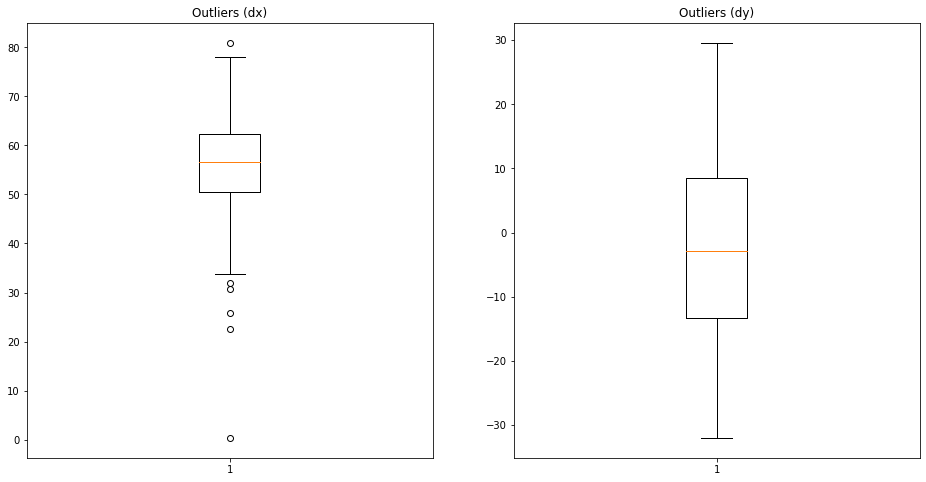

In [3]:
import matplotlib.pyplot as plt



# Dropping unsuccessful punts
for i in summarized_df.iterrows():
    if i[1]['Count'] != 2:
        delete_row = df.loc[(df['gameId'] == i[1]['gameId']) & (df['playId'] == i[1]['playId'])]
        df = df.drop(delete_row.index)
        
        
        
# Constructing target data
xy_dataset = {}

for i in range(int(len(df) / 2)):
    if df.iloc[i * 2]['playDirection'] == 'left':
        x = - (df.iloc[i * 2 + 1]['x'] - df.iloc[i * 2]['x'])
        y = df.iloc[i * 2 + 1]['y'] - df.iloc[i * 2]['y']
        start_x = df.iloc[i * 2]['x']
        start_y = df.iloc[i * 2]['y']
    else:
        x = df.iloc[i * 2 + 1]['x'] - df.iloc[i * 2]['x']
        y = - (df.iloc[i * 2 + 1]['y'] - df.iloc[i * 2]['y'])    
        start_x = 120 - df.iloc[i * 2]['x']
        start_y = 53.3 - df.iloc[i * 2]['y']
    xy_dataset[i] = [x, y, df.iloc[i * 2]['gameId'], df.iloc[i * 2]['playId'], start_x, start_y, df.iloc[i * 2]['playDirection']]
    
xy_df = pd.DataFrame(data=xy_dataset).T
xy_df.columns = ['dx', 'dy', 'gameId', 'playId', 'start_x', 'start_y', 'playDirection']

convert_cols = ['start_x', 'start_y', 'dx', 'dy']
for i in convert_cols:
    xy_df[i] = xy_df[i].astype(float, errors = 'raise')
    


# Dropping out of range data
out_of_range_data = []

for i in xy_df.iterrows():
    if i[1]['start_y'] > 53.3:
        out_of_range_data.append(i[0])
    if i[1]['start_x'] > 120 or i[1]['start_x'] < 0:
        out_of_range_data.append(i[0])

for i in out_of_range_data:
    xy_df = xy_df.drop(i)

xy_df.reset_index(drop=True, inplace=True)



# Data visualization and handling outliers
fig, axes = plt.subplots(1, 2, figsize=(16, 8))
axes[0].boxplot(xy_df['dx']);
axes[0].set_title('Outliers (dx)');
axes[1].boxplot(xy_df['dy']);
axes[1].set_title('Outliers (dy)');

data = xy_df['dx']

median = np.median(data)
upper_quartile = np.percentile(data, 75)
lower_quartile = np.percentile(data, 25)

iqr = upper_quartile - lower_quartile
upper_whisker = data[data<=upper_quartile+1.5*iqr].max()
lower_whisker = data[data>=lower_quartile-1.5*iqr].min()

for i in xy_df.iterrows():
    if i[1]['dx'] < lower_whisker or i[1]['dx'] > upper_whisker:
        xy_df = xy_df.drop(i[0])
        
xy_df.reset_index(drop=True, inplace=True)

## 4, Working with Features

Now we are going to build the feature dataset which could help train the model and predict the "Expected Landing Position". After reading the dataset description, I have decided to include the following features:

kickType (PFFScoutingData.csv) <br />
snapTime (PFFScoutingData.csv) <br />
operationTime (PFFScoutingData.csv) <br />
hangTime (PFFScoutingData.csv) <br />
kickDirectionActual (PFFScoutingData.csv) <br />
puntRushers (PFFScoutingData.csv) <br />
preSnapHomeScore (plays.csv) <br />
preSnapVisitorScore (plays.csv) <br />
height (players.csv)<br />
weight (players.csv)<br />

Among all these selected features, "puntRushers" will be used as a numerical data: the number of punt rushers in each occasion will be counted. "preSnapHomeScore" and "preSnapVisitorScore" will be used to determine whether the punting team is trailing (or tie) or leading while punting the football. Features can be changed or dropped any time depending on the correlation between the features and the target.

At the same time, we are going to clean the newly added data. We will clear all the columns containing null and investigate the correlation of features and targets using scatter plots. From plotting the graphs, snapTime and operationTime are the two features that have no correlation with the target data (Scatter plots of these two features are provided below). Therefore we will drop these two features. Other features will be used to train the model. 

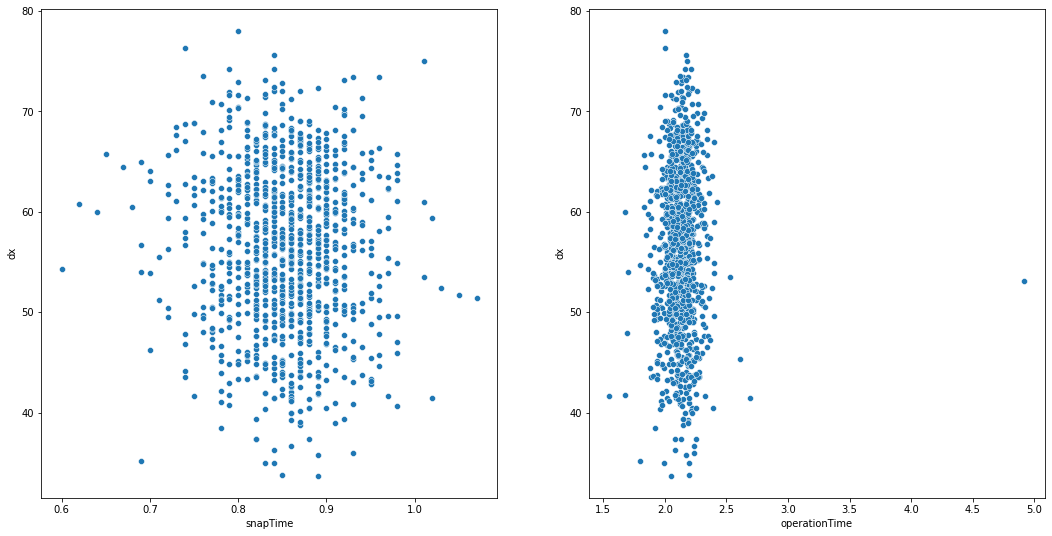

In [4]:
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=SettingWithCopyWarning)


# Reading data
pff = pd.read_csv('../input/nfl-big-data-bowl-2022/PFFScoutingData.csv')
plays_df = pd.read_csv('../input/nfl-big-data-bowl-2022/plays.csv')
players_df = pd.read_csv('../input/nfl-big-data-bowl-2022/players.csv')



# Merging features from PFF Scouting Data
pff_feature = pff[['gameId', 'playId', 'kickType', 'snapDetail', 'snapTime', 'operationTime', 'hangTime', 'kickDirectionActual', 'puntRushers']]
xy_df = pd.merge(xy_df, pff_feature, on=['gameId', 'playId'], how='left')

# Merging features from Plays
kicker_feature = plays_df[['gameId', 'playId', 'kickerId', 'preSnapHomeScore', 'preSnapVisitorScore']]
xy_df = pd.merge(xy_df, kicker_feature, on=['gameId', 'playId'], how='left')

# Merging features from Players
players_feature = players_df[['height', 'weight', 'nflId']]
xy_df = pd.merge(xy_df, players_feature, left_on = 'kickerId', right_on = 'nflId', how='left')

#newxydf = xy_df.copy()
#xy_df = newxydf

# Determining leading or trailing (tie)
xy_df['leading'] = 0
for i in xy_df.iterrows():
    if i[1]['playDirection'] == 'right':
        if i[1]['preSnapHomeScore'] > i[1]['preSnapVisitorScore']:
            xy_df['leading'][i[0]] = 1
    else:
        if i[1]['preSnapHomeScore'] < i[1]['preSnapVisitorScore']:
            xy_df['leading'][i[0]] = 1
            
# Counting punt rushers
xy_df['numPuntRushers'] = 0 # default: 0
for i in xy_df.iterrows():
    if pd.isnull(i[1]['puntRushers']) == False:
        xy_df['numPuntRushers'][i[0]] = xy_df['puntRushers'][i[0]].count(';') + 1
        
# Converting height to decimal form
xy_df = xy_df.rename(columns={'height': 'height_str'})
xy_df['height'] = 0.1
for i in xy_df.iterrows():
    xy_df['height'][i[0]] = float(i[1]['height_str'][0]) + float(i[1]['height_str'][2:]) / 12

# Dropping excessive columns
xy_df = xy_df.drop(columns=['kickerId', 'nflId', 'gameId', 'playId', 'playDirection', 'preSnapHomeScore', 'preSnapVisitorScore', 'puntRushers', 'height_str'])



# Dropping rows that contain null values
delete_rows = []

for i in xy_df.iterrows():
    for j in xy_df.columns:
        if pd.isnull(i[1][j]):
            delete_rows.append(i[0])
            
delete_rows = list(set(delete_rows))

for j in delete_rows:
    xy_df = xy_df.drop(j)
    
xy_df.reset_index(drop = True, inplace = True)



# Data Visualization and dropping features
f, axes = plt.subplots(1, 2, figsize=(18, 9))

sns.scatterplot(xy_df['snapTime'], xy_df['dx'], ax=axes[0]);
sns.scatterplot(xy_df['operationTime'], xy_df['dx'], ax=axes[1]);

xy_df = xy_df.drop(columns=['snapTime', 'operationTime'])
xy_df.reset_index(drop = True, inplace = True)

pd.options.mode.chained_assignment = None

## 5, Data cleaning for other datasets
We have constructed a dataset containing relevant features based on the 2020 NFL tracking data and cleaned it as well. The hidden cell below is used to handle the 2019 and 2018 NFL tracking data and merge all three datasets together.

In [5]:
# Loading NFL 2019 Tracking Data
df_2019 = pd.read_csv('../input/nfl-big-data-bowl-2022/tracking2019.csv')
df_2019 = df_2019.loc[df_2019['team'] == 'football']
df_2019 = df_2019.drop(columns = ['o', 'dir', 'nflId', 'jerseyNumber', 'position'])
df_2019 = df_2019.loc[(df_2019['event'] == 'punt') | (df_2019['event'] == 'punt_land') | (df_2019['event'] == 'punt_received')]
summarized_df_2019 = pd.DataFrame(df_2019.groupby(['gameId', 'playId']).size().reset_index(name = "Count"))

# Dropping unsuccessful punts
for i in summarized_df_2019.iterrows():
    if i[1]['Count'] != 2:
        delete_row = df_2019.loc[(df_2019['gameId'] == i[1]['gameId']) & (df_2019['playId'] == i[1]['playId'])]
        df_2019 = df_2019.drop(delete_row.index)
        
# Constructing target data
xy_dataset = {}
for i in range(int(len(df_2019) / 2)):
    if df_2019.iloc[i * 2]['playDirection'] == 'left':
        x = - (df_2019.iloc[i * 2 + 1]['x'] - df_2019.iloc[i * 2]['x'])
        y = df_2019.iloc[i * 2 + 1]['y'] - df_2019.iloc[i * 2]['y']
        start_x = df_2019.iloc[i * 2]['x']
        start_y = df_2019.iloc[i * 2]['y']
    else:
        x = df_2019.iloc[i * 2 + 1]['x'] - df_2019.iloc[i * 2]['x']
        y = - (df_2019.iloc[i * 2 + 1]['y'] - df_2019.iloc[i * 2]['y'])    
        start_x = 120 - df_2019.iloc[i * 2]['x']
        start_y = 53.3 - df_2019.iloc[i * 2]['y']
    xy_dataset[i] = [x, y, df_2019.iloc[i * 2]['gameId'], df_2019.iloc[i * 2]['playId'], start_x, start_y, df_2019.iloc[i * 2]['playDirection']]
xy_df_2019 = pd.DataFrame(data=xy_dataset).T
xy_df_2019.columns = ['dx', 'dy', 'gameId', 'playId', 'start_x', 'start_y', 'playDirection']
convert_cols = ['start_x', 'start_y', 'dx', 'dy']
for i in convert_cols:
    xy_df_2019[i] = xy_df_2019[i].astype(float, errors = 'raise')

# Dropping out of range data
out_of_range_data = []
for i in xy_df_2019.iterrows():
    if i[1]['start_y'] > 53.3:
        out_of_range_data.append(i[0])
    if i[1]['start_x'] > 120 or i[1]['start_x'] < 0:
        out_of_range_data.append(i[0])
for i in out_of_range_data:
    xy_df_2019 = xy_df_2019.drop(i)
xy_df_2019.reset_index(drop=True, inplace=True)

# Handling outliers
data = xy_df_2019['dx']
median = np.median(data)
upper_quartile = np.percentile(data, 75)
lower_quartile = np.percentile(data, 25)
iqr = upper_quartile - lower_quartile
upper_whisker = data[data<=upper_quartile+1.5*iqr].max()
lower_whisker = data[data>=lower_quartile-1.5*iqr].min()
for i in xy_df_2019.iterrows():
    if i[1]['dx'] < lower_whisker or i[1]['dx'] > upper_whisker:
        xy_df_2019 = xy_df_2019.drop(i[0])
xy_df_2019.reset_index(drop=True, inplace=True)

# Reading data
pff = pd.read_csv('../input/nfl-big-data-bowl-2022/PFFScoutingData.csv')
plays_df = pd.read_csv('../input/nfl-big-data-bowl-2022/plays.csv')
players_df = pd.read_csv('../input/nfl-big-data-bowl-2022/players.csv')

# Merging features from PFF Scouting Data
pff_feature = pff[['gameId', 'playId', 'kickType', 'snapDetail', 'snapTime', 'operationTime', 'hangTime', 'kickDirectionActual', 'puntRushers']]
xy_df_2019 = pd.merge(xy_df_2019, pff_feature, on=['gameId', 'playId'], how='left')

# Merging features from Plays
kicker_feature = plays_df[['gameId', 'playId', 'kickerId', 'preSnapHomeScore', 'preSnapVisitorScore']]
xy_df_2019 = pd.merge(xy_df_2019, kicker_feature, on=['gameId', 'playId'], how='left')

# Merging features from Players
players_feature = players_df[['height', 'weight', 'nflId']]
xy_df_2019 = pd.merge(xy_df_2019, players_feature, left_on = 'kickerId', right_on = 'nflId', how='left')

# Determining leading or trailing (tie)
xy_df_2019['leading'] = 0
for i in xy_df_2019.iterrows():
    if i[1]['playDirection'] == 'right':
        if i[1]['preSnapHomeScore'] > i[1]['preSnapVisitorScore']:
            xy_df_2019['leading'][i[0]] = 1
    else:
        if i[1]['preSnapHomeScore'] < i[1]['preSnapVisitorScore']:
            xy_df_2019['leading'][i[0]] = 1
            
# Counting punt rushers
xy_df_2019['numPuntRushers'] = 0 # default: 0
for i in xy_df_2019.iterrows():
    if pd.isnull(i[1]['puntRushers']) == False:
        xy_df_2019['numPuntRushers'][i[0]] = xy_df_2019['puntRushers'][i[0]].count(';') + 1
        
# Converting height to decimal form
xy_df_2019 = xy_df_2019.rename(columns={'height': 'height_str'})
xy_df_2019['height'] = 0.1
for i in xy_df_2019.iterrows():
    if i[1]['nflId'] == 37267: # After investigation, all columns with nflId 37267 has a height issue and thus must be dropped
        xy_df_2019 = xy_df_2019.drop(i[0])
        continue
    xy_df_2019['height'][i[0]] = float(i[1]['height_str'][0]) + float(i[1]['height_str'][2:]) / 12

# Dropping excessive columns
xy_df_2019 = xy_df_2019.drop(columns=['kickerId', 'nflId', 'gameId', 'playId', 'playDirection', 'preSnapHomeScore', 'preSnapVisitorScore', 'puntRushers', 'height_str'])

# Dropping rows that contain null values
delete_rows = []
for i in xy_df_2019.iterrows():
    for j in xy_df_2019.columns:
        if pd.isnull(i[1][j]):
            delete_rows.append(i[0]) 
delete_rows = list(set(delete_rows))
for j in delete_rows:
    xy_df_2019 = xy_df_2019.drop(j)
xy_df_2019.reset_index(drop = True, inplace = True)

## Dropping features
xy_df_2019 = xy_df_2019.drop(columns=['snapTime', 'operationTime'])
xy_df_2019.reset_index(drop = True, inplace = True)





# Loading NFL 2018 Tracking Data
df_2018 = pd.read_csv('../input/nfl-big-data-bowl-2022/tracking2018.csv')
df_2018 = df_2018.loc[df_2018['team'] == 'football']
df_2018 = df_2018.drop(columns = ['o', 'dir', 'nflId', 'jerseyNumber', 'position'])
df_2018 = df_2018.loc[(df_2018['event'] == 'punt') | (df_2018['event'] == 'punt_land') | (df_2018['event'] == 'punt_received')]
summarized_df_2018 = pd.DataFrame(df_2018.groupby(['gameId', 'playId']).size().reset_index(name = "Count"))
summarized_df_2018

# Dropping unsuccessful punts
for i in summarized_df_2018.iterrows():
    if i[1]['Count'] != 2:
        delete_row = df_2018.loc[(df_2018['gameId'] == i[1]['gameId']) & (df_2018['playId'] == i[1]['playId'])]
        df_2018 = df_2018.drop(delete_row.index)

# Constructing target data
xy_dataset = {}
for i in range(int(len(df_2018) / 2)):
    if df_2018.iloc[i * 2]['playDirection'] == 'left':
        x = - (df_2018.iloc[i * 2 + 1]['x'] - df_2018.iloc[i * 2]['x'])
        y = df_2018.iloc[i * 2 + 1]['y'] - df_2018.iloc[i * 2]['y']
        start_x = df_2018.iloc[i * 2]['x']
        start_y = df_2018.iloc[i * 2]['y']
    else:
        x = df_2018.iloc[i * 2 + 1]['x'] - df_2018.iloc[i * 2]['x']
        y = - (df_2018.iloc[i * 2 + 1]['y'] - df_2018.iloc[i * 2]['y'])    
        start_x = 120 - df_2018.iloc[i * 2]['x']
        start_y = 53.3 - df_2018.iloc[i * 2]['y']
    xy_dataset[i] = [x, y, df_2018.iloc[i * 2]['gameId'], df_2018.iloc[i * 2]['playId'], start_x, start_y, df_2018.iloc[i * 2]['playDirection']]
xy_df_2018 = pd.DataFrame(data=xy_dataset).T
xy_df_2018.columns = ['dx', 'dy', 'gameId', 'playId', 'start_x', 'start_y', 'playDirection']
convert_cols = ['start_x', 'start_y', 'dx', 'dy']
for i in convert_cols:
    xy_df_2018[i] = xy_df_2018[i].astype(float, errors = 'raise')
    
# Dropping out of range data
out_of_range_data = []
for i in xy_df_2018.iterrows():
    if i[1]['start_y'] > 53.3:
        out_of_range_data.append(i[0])
    if i[1]['start_x'] > 120 or i[1]['start_x'] < 0:
        out_of_range_data.append(i[0])
for i in out_of_range_data:
    xy_df_2018 = xy_df_2018.drop(i)

xy_df_2018.reset_index(drop=True, inplace=True)

# Handling outliers
data = xy_df_2018['dx']
median = np.median(data)
upper_quartile = np.percentile(data, 75)
lower_quartile = np.percentile(data, 25)
iqr = upper_quartile - lower_quartile
upper_whisker = data[data<=upper_quartile+1.5*iqr].max()
lower_whisker = data[data>=lower_quartile-1.5*iqr].min()
for i in xy_df_2018.iterrows():
    if i[1]['dx'] < lower_whisker or i[1]['dx'] > upper_whisker:
        xy_df_2018 = xy_df_2018.drop(i[0])
xy_df_2018.reset_index(drop=True, inplace=True)

# Reading data
pff = pd.read_csv('../input/nfl-big-data-bowl-2022/PFFScoutingData.csv')
plays_df = pd.read_csv('../input/nfl-big-data-bowl-2022/plays.csv')
players_df = pd.read_csv('../input/nfl-big-data-bowl-2022/players.csv')

# Merging features from PFF Scouting Data !!!
pff_feature = pff[['gameId', 'playId', 'kickType', 'snapDetail', 'snapTime', 'operationTime', 'hangTime', 'kickDirectionActual', 'puntRushers']]
xy_df_2018 = pd.merge(xy_df_2018, pff_feature, on=['gameId', 'playId'], how='left')

# Merging features from Plays !!!
kicker_feature = plays_df[['gameId', 'playId', 'kickerId', 'preSnapHomeScore', 'preSnapVisitorScore']]
xy_df_2018 = pd.merge(xy_df_2018, kicker_feature, on=['gameId', 'playId'], how='left')

# Merging features from Players !!!
players_feature = players_df[['height', 'weight', 'nflId']]
xy_df_2018 = pd.merge(xy_df_2018, players_feature, left_on = 'kickerId', right_on = 'nflId', how='left')

# Determining leading or trailing (tie)
xy_df_2018['leading'] = 0
for i in xy_df_2018.iterrows():
    if i[1]['playDirection'] == 'right':
        if i[1]['preSnapHomeScore'] > i[1]['preSnapVisitorScore']:
            xy_df_2018['leading'][i[0]] = 1
    else:
        if i[1]['preSnapHomeScore'] < i[1]['preSnapVisitorScore']:
            xy_df_2018['leading'][i[0]] = 1
            
# Counting punt rushers
xy_df_2018['numPuntRushers'] = 0 # default: 0
for i in xy_df_2018.iterrows():
    if pd.isnull(i[1]['puntRushers']) == False:
        xy_df_2018['numPuntRushers'][i[0]] = xy_df_2018['puntRushers'][i[0]].count(';') + 1
    
# Converting height to decimal form
xy_df_2018 = xy_df_2018.rename(columns={'height': 'height_str'})
xy_df_2018['height'] = 0.1
for i in xy_df_2018.iterrows():
    if i[1]['nflId'] == 37267: # After investigation, all columns with nflId 37267 has a height issue and thus must be dropped
        xy_df_2018 = xy_df_2018.drop(i[0])
        continue
    xy_df_2018['height'][i[0]] = float(i[1]['height_str'][0]) + float(i[1]['height_str'][2:]) / 12
xy_df_2018.reset_index(drop = True, inplace = True)

# Dropping excessive columns
xy_df_2018 = xy_df_2018.drop(columns=['kickerId', 'nflId', 'gameId', 'playId', 'playDirection', 'preSnapHomeScore', 'preSnapVisitorScore', 'puntRushers', 'height_str'])

# Dropping rows that contain null values
delete_rows = []
for i in xy_df_2018.iterrows():
    for j in xy_df_2018.columns:
        if pd.isnull(i[1][j]):
            delete_rows.append(i[0])
delete_rows = list(set(delete_rows))
for j in delete_rows:
    xy_df_2018 = xy_df_2018.drop(j)
xy_df_2018.reset_index(drop = True, inplace = True)

## Dropping features
xy_df_2018 = xy_df_2018.drop(columns=['snapTime', 'operationTime'])
xy_df_2018.reset_index(drop = True, inplace = True)

## 6, Handling Categorical Variables

Last but not least, we will merge all three cleaned datasets together and use one hot encoder to convert all the categorical variables ("kickType", "snapDetail", "kickDirectionActual") in order to convert them to numerical data types, maintain the consistency of the dataset and fit a training model.

In [6]:
# Concatenating all three dataframes
sdf = pd.concat([xy_df, xy_df_2019, xy_df_2018], axis=0)


# OneHotEncoder
object_cols = ['kickType', 'snapDetail', 'kickDirectionActual']     # try to use programming variables
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
OH_cols = pd.DataFrame(OH_encoder.fit_transform(sdf[object_cols]))
OH_cols.index = sdf.index
num_X_train = sdf.drop(object_cols, axis=1)
OH_sdf = pd.concat([num_X_train, OH_cols], axis=1)
OH_sdf.reset_index(inplace=True)
OH_sdf

,index,dx,dy,start_x,start_y,hangTime,weight,leading,numPuntRushers,height,...,1,2,3,4,5,6,7,8,9,10
0,0,67.64,-9.57,78.04,23.02,4.50,208,0,1,6.000000,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
1,1,58.23,21.75,75.65,29.35,4.15,208,0,0,6.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2,2,66.05,-10.35,92.15,22.77,4.64,205,1,0,6.000000,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,3,46.50,16.81,89.57,28.94,4.69,205,1,0,6.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,4,44.77,29.60,66.24,23.98,4.16,208,0,2,6.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3530,1270,54.27,2.24,99.80,23.60,4.24,211,1,0,6.083333,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3531,1271,48.43,17.80,93.29,26.34,4.08,211,0,0,6.083333,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3532,1272,67.97,-13.18,88.44,29.48,4.26,241,0,2,6.416667,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
3533,1273,62.44,-15.15,112.64,23.25,4.58,205,1,1,6.083333,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


## 7, Model Creation

Here we are going to create a model to predict the "Expected Landing Position". We will use two models in this instance: XGBRegressor (which is more efficient but slightly less accurate) and XGBRegressor with BaggingRegessor (which is more accurate but takes much longer time). Test scores of cross validation and mean absolute error of 20% of the dataset will be shown as output.

In [7]:
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.multioutput import MultiOutputRegressor 
from sklearn.ensemble import BaggingRegressor
from sklearn.model_selection import cross_val_score

# Divide dataset and train test split
X = OH_sdf.drop(columns = ['dx', 'dy'])
y = OH_sdf[['dx', 'dy']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

# XGBRegressor
xgb = MultiOutputRegressor(XGBRegressor(n_estimators=700, learning_rate=0.01, n_jobs=4))
xgb.fit(X_train, y_train)
preds = xgb.predict(X_test)
mae = mean_absolute_error(preds, y_test)
print("Mean Absoulte Error of XGBRegressor: " + str(mae))
scores = -1 * cross_val_score(xgb, X, y, cv=5, scoring='neg_mean_absolute_error')
print("Cross Valiation Average Mean Absolute Error Score for XGBRegressor: " + str(scores.mean()))

# XGBRegressor with BaggingRegressor
xgbbag = MultiOutputRegressor(BaggingRegressor(base_estimator=XGBRegressor(n_estimators=700, learning_rate=0.01, n_jobs=4)))
xgbbag.fit(X_train, y_train)
preds = xgbbag.predict(X_test)
mae = mean_absolute_error(preds, y_test)
print("Mean Absoulte Error of XGBRegressor with BaggingRegressor: " + str(mae))
scores = -1 * cross_val_score(xgbbag, X, y, cv=5, scoring='neg_mean_absolute_error')
print("Cross Valiation Average Mean Absolute Error Score for XGBRegressor with BaggingRegressor: " + str(scores.mean()))

Mean Absoulte Error of XGBRegressor: 4.7648721127714655
Cross Valiation Average Mean Absolute Error Score for XGBRegressor: 4.797115827507968
Mean Absoulte Error of XGBRegressor with BaggingRegressor: 4.7409529130961
Cross Valiation Average Mean Absolute Error Score for XGBRegressor with BaggingRegressor: 4.754674967768496


## 8, Example of Model Application: 2016 NFL Season Week 10 Pittsburgh Steelers vs. Dallas Cowboys 

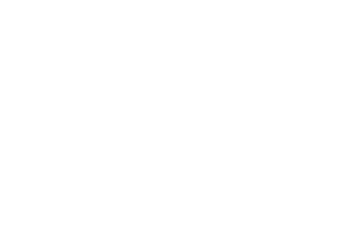

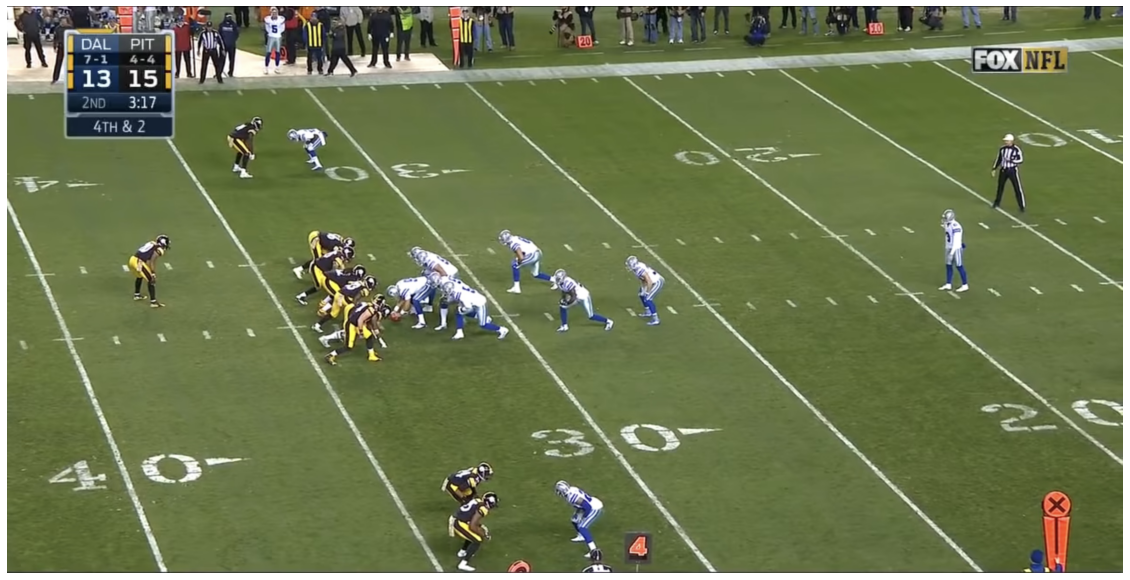

In [8]:
from PIL import Image
img = Image.open('../input/insertimage/IMG_0032.jpg')
plt.grid(False)
plt.axis('off')
plt.figure(figsize = (20, 20))
plt.axis('off')
plt.imshow(img);

Now we are going to apply this trained model on a real life instance to evaluate whether the predicted landing spot is in an area which the returner has control. Here we are going to use a return in the game between Pittsburgh Steelers and Dallas Cowboys in week 10 in the 2016 NFL Season as an example. With 3 minutes 17 seconds left in the 2nd quarter, Dallas Cowboys had a chance to punt the ball at around 90.75 yards on the x axis and 23.16 yards on the y axis. For the features, we can observe that there are no punt rushers and the punting team is trailing behind. For other features, I am going to use the most frequent or mean value of all the punts that the player Chris Jones has made in the past, including hangTime, kickType, direction and snapDetail. Here I am going to use the XGBRegressor in order to perform more efficient calculations. After calculation and model prediction, we can observe that the actual landing spot of the football is at around 62 yards on ths x axis and -22 yards (just out of bounds), which was a position that the receiver Antonio Brown could catch the ball. Thus this model is valid and could be used to predict the position of returners before a punt.

In [9]:
player = players_df.iloc[players_df.loc[(players_df['displayName'] == 'Chris Jones') & (players_df['collegeName'] == 'Carson-Newman')].index[0]]
nflId = player['nflId']
height = player['height']
weight = player['weight']
egdf = plays_df.loc[plays_df['kickerId'] == nflId][['gameId', 'playId']]
egdf = pd.merge(egdf, pff[['gameId', 'playId', 'hangTime', 'kickType', 'kickDirectionActual', 'snapDetail']], on=['gameId', 'playId'], how='left')
hangTime = egdf['hangTime'].mean()
kickType = egdf['kickType'].mode()[0]
leading = False
direction = egdf['kickDirectionActual'].mode()[0]
start_x = 90.75
start_y = 23.16333
snapDetail = egdf['snapDetail'].mode()[0]
numPuntRushers = 0

def construct(start_x, start_y, kickType, snapDetail, hangTime, direction, weight, leading, numPuntRushers, height):
    height = float(height[0]) + float(height[2:]) / 12
    if leading == False:
        leading = 1
    else:
        leading = 0
    eg_test = pd.DataFrame(data = {'1': [start_x, start_y, kickType, snapDetail, hangTime, direction, weight, leading, numPuntRushers, height]})
    eg_test = eg_test.T
    eg_test.columns = ['start_x', 'start_y', 'kickType', 'snapDetail', 'hangTime', 'kickDirectionActual', 'weight', 'leading', 'numPuntRushers', 'height']
    return eg_test

def return_test_result(eg_test):
    global sdf
    sdf2 = pd.concat([sdf, eg_test], axis=0)
    sdf2.reset_index(drop = True, inplace = True)
    object_cols = ['kickType', 'snapDetail', 'kickDirectionActual']     # try to use programming variables
    OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
    OH_cols = pd.DataFrame(OH_encoder.fit_transform(sdf2[object_cols]))
    OH_cols.index = sdf2.index
    num_X_train = sdf2.drop(object_cols, axis=1)
    OH_sdf = pd.concat([num_X_train, OH_cols], axis=1)
    OH_sdf.reset_index(drop = True, inplace = True)
    eg_test = OH_sdf.iloc[len(OH_sdf) - 1]
    OH_sdf = OH_sdf.drop(len(OH_sdf) - 1)
    y = OH_sdf[['dx', 'dy']]
    X = OH_sdf.drop(columns = ['dx', 'dy'])
    eg_test = pd.DataFrame(eg_test.drop(['dx', 'dy'])).T
    xgb = MultiOutputRegressor(XGBRegressor(n_estimators=700, learning_rate=0.01, n_jobs=4))
    xgb.fit(X, y)
    return xgb.predict(eg_test)
    
eg_test = construct(start_x, start_y, kickType, snapDetail, hangTime, direction, weight, leading, numPuntRushers, height)
preds = return_test_result(eg_test)
print('dx Prediction: ' + str(preds[0][0]))
print('dy Prediction: ' + str(preds[0][1]))

dx Prediction: 58.36969
dy Prediction: -16.134647


## 9, Conclusion

This notebook provides a new insight of understanding the importance of punt and predicting the punt yardage. By using the machine learning model in this notebook, one is able to calculate the approximate displacement of a punted football, also known as "Expected Landing Position", by gathering data of starting position (on both x and y axis), kick type, hang time, kick direciton, number of punt rushers, whether the opponent is leading or not, the height and the weight of the punter. With the help of this metric, NFL teams could avoid positioning themselves in disadvangeous situations by performing better at returning, gaining more return yardages and facilitate the first offensive possesion after the punt from the opponent. Thank you for reading my notebook and I appreciate your time.

Image Source: https://www.youtube.com/watch?v=9n5UzEek6X8&t=3369s (Timestamp: 56:01) <br />
Stats Source: https://www.pro-football-reference.com/boxscores/201611130pit.htm